<a href="https://colab.research.google.com/github/zLolz-ZK/Image-Classification/blob/master/Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [ ]:
!pip install kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                 title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
imoore/60k-stack-overflow-questions-with-quality-rate               60k Stack Overflow Questions with Quality Rating     21MB  2020-09-08 09:26:05            662  
ihelon/lego-minifigures-classification                              LEGO Minifigures Classification                      12MB  2020-09-08 16:48:53            662  
anikannal/solar-power-generation-data                               Solar Power Generation Data                           2MB  2020-08-18 15:52:03           2707  
douglaskgaraujo/opportunity-insights-real-time-economic-tracker-us  Opportunity Insights real time Economic Tracker US   22MB  2020-09-07 18:23:07

In [ ]:
!mkdir training
!cd training
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:50<00:00, 34.8MB/s]
100% 5.20G/5.20G [01:50<00:00, 50.4MB/s]


In [ ]:
!pwd

/content


In [ ]:
from zipfile import ZipFile
file_name='skin-cancer-mnist-ham10000.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finished!!!')

finished!!!


In [ ]:
df_data = pd.read_csv('HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# identify lession and with lesion_id
df = df_data.groupby('lesion_id').count()
# filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [ ]:
base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

classes=['nv','mel','bkl', 'bcc', 'akiec', 'vasc', 'df']

for cl in classes:
    cl = os.path.join(train_dir, cl)
    os.mkdir(cl)
for cl in classes:
    cl = os.path.join(val_dir, cl)
    os.mkdir(cl)

In [ ]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [ ]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [ ]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [ ]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [ ]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [ ]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [ ]:
#identify validation rows
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']

print(len(df_train))
print(len(df_val))

9077
938


In [ ]:
df_train['dx'].value_counts()
df_val['dx'].value_counts()
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('ham10000_images_part_1')
folder_2 = os.listdir('ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

for image in train_list:    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    if fname in folder_1:
        # source path to image
        src = os.path.join('ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
def num_of_images(train = '', val = ''):
  base = 'base_dir'
  val_dir = 'val_dir'
  train_dir = 'train_dir'
  print(train_dir if train == 'train' else '', val_dir if val == 'val' else '' )
  for cl in classes:
    
    print(
        len(os.listdir(os.path.join(base, train_dir, cl))) if train == 'train' else '', 
        len(os.listdir(os.path.join(base, val_dir, cl))) if val == 'val' else ''
          )
num_of_images('train','val')

train_dir val_dir
6004 751
5920 39
5920 75
5858 30
5217 26
5290 11
4410 6


In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 40
val_batch_size = 40
image_size = 150

In [ ]:
for item in classes:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(150,150),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 5954 images belonging to 1 classes.
Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
transformation_ratio = .05
datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input)

train_batches = datagen.flow_from_directory(
      train_path,
      target_size=(image_size,image_size),
      batch_size=train_batch_size,
      shuffle = True,
      class_mode = 'sparse'
      )

valid_batches = datagen.flow_from_directory(
    valid_path,
    target_size=(image_size,image_size),
    batch_size=val_batch_size,
    shuffle = True,
    class_mode = 'sparse'
    )

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(
    valid_path,
    target_size = (image_size,image_size),
    batch_size = 1,
    shuffle = False,
    class_mode = 'sparse'
    )
num_of_images('train','val')

Found 38619 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
train_dir val_dir
6004 751
5920 39
5920 75
5858 30
5217 26
5290 11
4410 6


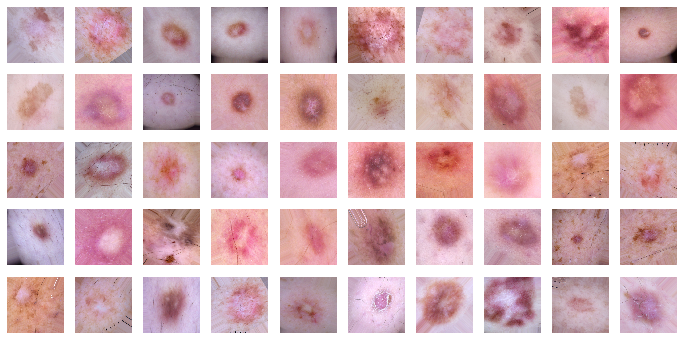

In [ ]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [ ]:
#Creating the Model
#iresnetv2 = iresnetv2.layers[-2].output


In [ ]:
#iresnetv2.layers.pop()
iresnetv2.summary()

In [ ]:
#model 1 acc 70% val accu 81% loss 0.8~0.9
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import  Model
model2 = tf.keras.models.Sequential([
                                iresnetv2,

                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(256,activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(64,activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(7,activation='softmax')
])


#model = Model(vgg.input, predictions)

In [ ]:
# model 2 1/2 freezed & rest 1/2 trained
inresnetv2 = tf.keras.applications.InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)
for i,layer in enumerate(inresnetv2.layers):
  print(i,layer)

#find the mid point

In [ ]:
print(len(classes))
model.summary()

7
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 7)              

In [ ]:
model.compile(optimizer='nadam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']
              )

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# New Section

In [ ]:
%pwd
import os
os.getcwd()

'/content'

In [ ]:
file_path = os.getcwd()

top_weights_path = os.path.join(os.path.abspath(file_path), 'top_model_weights_iresnetv2.h5')
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(top_weights_path, monitor='val_acc',
                                        verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=0),
    
]

epochs  = 25
history = model.fit(
    train_batches, 
    steps_per_epoch=train_steps,
    validation_data=valid_batches,
    validation_steps=val_steps,
    epochs=epochs,
     callbacks = callbacks_list 
                    )

In [ ]:
!cd training


In [ ]:
!mv model.h5 ..

In [ ]:
!ls

base_dir		HAM10000_images_part_2	hmnist_8_8_RGB.csv
drive			HAM10000_metadata.csv	kaggle.json
ham10000_images_part_1	hmnist_28_28_L.csv	sample_data
HAM10000_images_part_1	hmnist_28_28_RGB.csv	skin-cancer-mnist-ham10000.zip
ham10000_images_part_2	hmnist_8_8_L.csv	training


In [ ]:
!mv model.h5 /drive

mv: cannot stat 'model.h5': No such file or directory


In [ ]:
/model.h5

In [ ]:
#Trial model 1 using Xception refer keras tutorials
# https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
) 

base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model2 = keras.Model(inputs, outputs)

model2.summary()